/tmp/ipykernel_21971/559325450.py:55: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_21971/559325450.py:55: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_21971/559325450.py:55: UserWarning: Glyph 21494 (\N{CJK UNIFIED IDEOGRAPH-53F6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_21971/559325450.py:55: UserWarning: Glyph 32511 (\N{CJK UNIFIED IDEOGRAPH-7EFF}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_21971/559325450.py:55: UserWarning: Glyph 32032 (\N{CJK UNIFIED IDEOGRAPH-7D20}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_21971/559325450.py:55: UserWarning: Glyph 27987 (\N{CJK UNIFIED IDEOGRAPH-6D53}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_21971/559325450.py:55: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.tight_l

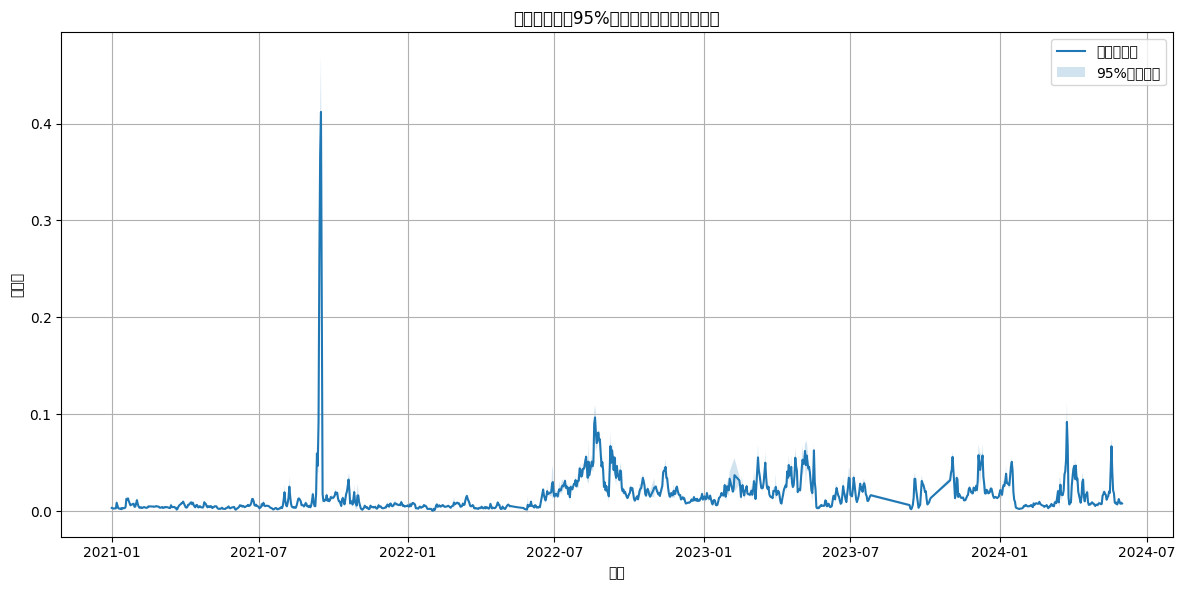

In [1]:
import datetime
import csv
import aie
import pandas as pd
import numpy as np
import chardet
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# 步骤1: 数据准备
csv_file = '/root/Download/Modis-algae-aliyun/aie-taihu/00-lanshanzui.csv'

# 检测文件编码
with open(csv_file, 'rb') as f:
    result = chardet.detect(f.read())

# 使用探测到的编码读取文件
df = pd.read_csv(csv_file, encoding=result['encoding'])

# 将日期列转换为日期时间格式
df['date'] = pd.to_datetime(df['date'])

# 设置日期为索引
df.set_index('date', inplace=True)

# 对叶绿素列进行线性插值
df['chla'] = df['chla'].interpolate(method='linear')

# 按日期分组并计算每日的统计数据
daily_stats = df['chla'].resample('D').agg(['mean', 'std', 'count'])

# 计算95%置信区间
confidence_interval = 1.96 * daily_stats['std'] / np.sqrt(daily_stats['count'])

# 计算置信区间的上下限
daily_stats['lower_ci'] = daily_stats['mean'] - confidence_interval
daily_stats['upper_ci'] = daily_stats['mean'] + confidence_interval

# 对平均值和置信区间上下限进行线性插值
daily_stats_interpolated = daily_stats.interpolate(method='linear')

# 绘制叶绿素和置信区间
plt.figure(figsize=(12, 6))
plt.plot(daily_stats_interpolated.index, daily_stats_interpolated['mean'], label='平均叶绿素')
plt.fill_between(daily_stats_interpolated.index, daily_stats_interpolated['lower_ci'], daily_stats_interpolated['upper_ci'], alpha=0.2, label='95%置信区间')
plt.xlabel('日期')
plt.ylabel('叶绿素')
plt.title('叶绿素浓度及95%置信区间（线性插值后）')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 与叶绿素a的相关性

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# 读取两个CSV文件
mod_df = pd.read_csv('特征和密度结果_MODIS_MOD09GA_061_20241029_插值填充3.csv')
mcd_df = pd.read_csv('特征和密度结果_MODIS_MCD18C2_061_20241027_插值填充.csv')

# 重命名MCD数据框中的密度列,以区分来源
mcd_df = mcd_df.rename(columns={
    'density_mean': 'density_mean_mcd',
    'density_lower': 'density_lower_mcd', 
    'density_upper': 'density_upper_mcd'
})

# 重命名MOD数据框中的密度列
mod_df = mod_df.rename(columns={
    'density_mean': 'density_mean_mod',
    'density_lower': 'density_lower_mod',
    'density_upper': 'density_upper_mod'
})

# 合并两个数据框,以date为键
merged_df = pd.merge(mod_df, mcd_df, on='date')

# 计算两个来源的平均值作为最终密度值
merged_df['density_mean'] = merged_df['density_mean_mod']
merged_df['density_lower'] = merged_df['density_lower_mod']
merged_df['density_upper'] = merged_df['density_upper_mod']

# 将daily_stats_interpolated转换为DataFrame并重置索引
daily_stats_df = daily_stats_interpolated.reset_index()

# 确保日期列格式一致
daily_stats_df['date'] = pd.to_datetime(daily_stats_df['date']).dt.strftime('%Y/%m/%d')
merged_df['date'] = pd.to_datetime(merged_df['date']).dt.strftime('%Y/%m/%d')

# 合并叶绿素数据
merged_df = pd.merge(merged_df, daily_stats_df[['date', 'mean', 'lower_ci', 'upper_ci']], on='date', how='left')

# 重命名叶绿素相关列
merged_df = merged_df.rename(columns={
    'mean': 'chla_mean',
    'lower_ci': 'chla_lower',
    'upper_ci': 'chla_upper'
})



chla_mean 与各特征的相关性排序:
b4: -0.0520
b3: -0.0516
b2: -0.0515
b5: -0.0450
GMT_0000_PAR: 0.0336
GMT_0300_PAR: 0.0320
GMT_1200_PAR: nan
GMT_1500_PAR: nan
GMT_1800_PAR: nan
PPDI: 0.0562
b1: -0.0526
PAI: -0.0309
DAPAR: 0.0293
GMT_0600_PAR: 0.0233
b6: -0.0228
PDVI: 0.0225
evi: -0.0220
ndci: 0.0218
nrfi: -0.0215
GMT_2100_PAR: -0.0215
APAR: -0.0215
MPAR: 0.0196
b7: -0.0184
GMT_0900_PAR: 0.0177
FAI: -0.0028
ndvi: 0.0014

chla_lower 与各特征的相关性排序:
b1: -0.0518
b4: -0.0512
b2: -0.0511
b3: -0.0510
b5: -0.0448
GMT_0000_PAR: 0.0297
GMT_0300_PAR: 0.0283
GMT_1200_PAR: nan
GMT_1500_PAR: nan
GMT_1800_PAR: nan
PPDI: 0.0518
PAI: -0.0346
GMT_2100_PAR: -0.0248
APAR: -0.0248
DAPAR: 0.0246
b6: -0.0204
nrfi: -0.0202
PDVI: 0.0184
GMT_0600_PAR: 0.0178
evi: -0.0172
b7: -0.0167
ndci: 0.0164
MPAR: 0.0163
GMT_0900_PAR: 0.0131
FAI: -0.0022
ndvi: 0.0003

chla_upper 与各特征的相关性排序:
b4: -0.0488
b3: -0.0483
b2: -0.0480
b5: -0.0411
GMT_0000_PAR: 0.0323
GMT_0300_PAR: 0.0302
GMT_1200_PAR: nan
GMT_1500_PAR: nan
GMT_1800_PAR: nan
PPDI:

/tmp/ipykernel_21971/3212486166.py:36: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_21971/3212486166.py:36: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_21971/3212486166.py:36: UserWarning: Glyph 19982 (\N{CJK UNIFIED IDEOGRAPH-4E0E}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_21971/3212486166.py:36: UserWarning: Glyph 30446 (\N{CJK UNIFIED IDEOGRAPH-76EE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_21971/3212486166.py:36: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_21971/3212486166.py:36: UserWarning: Glyph 21464 (\N{CJK UNIFIED IDEOGRAPH-53D8}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_21971/3212486166.py:36: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  plt.

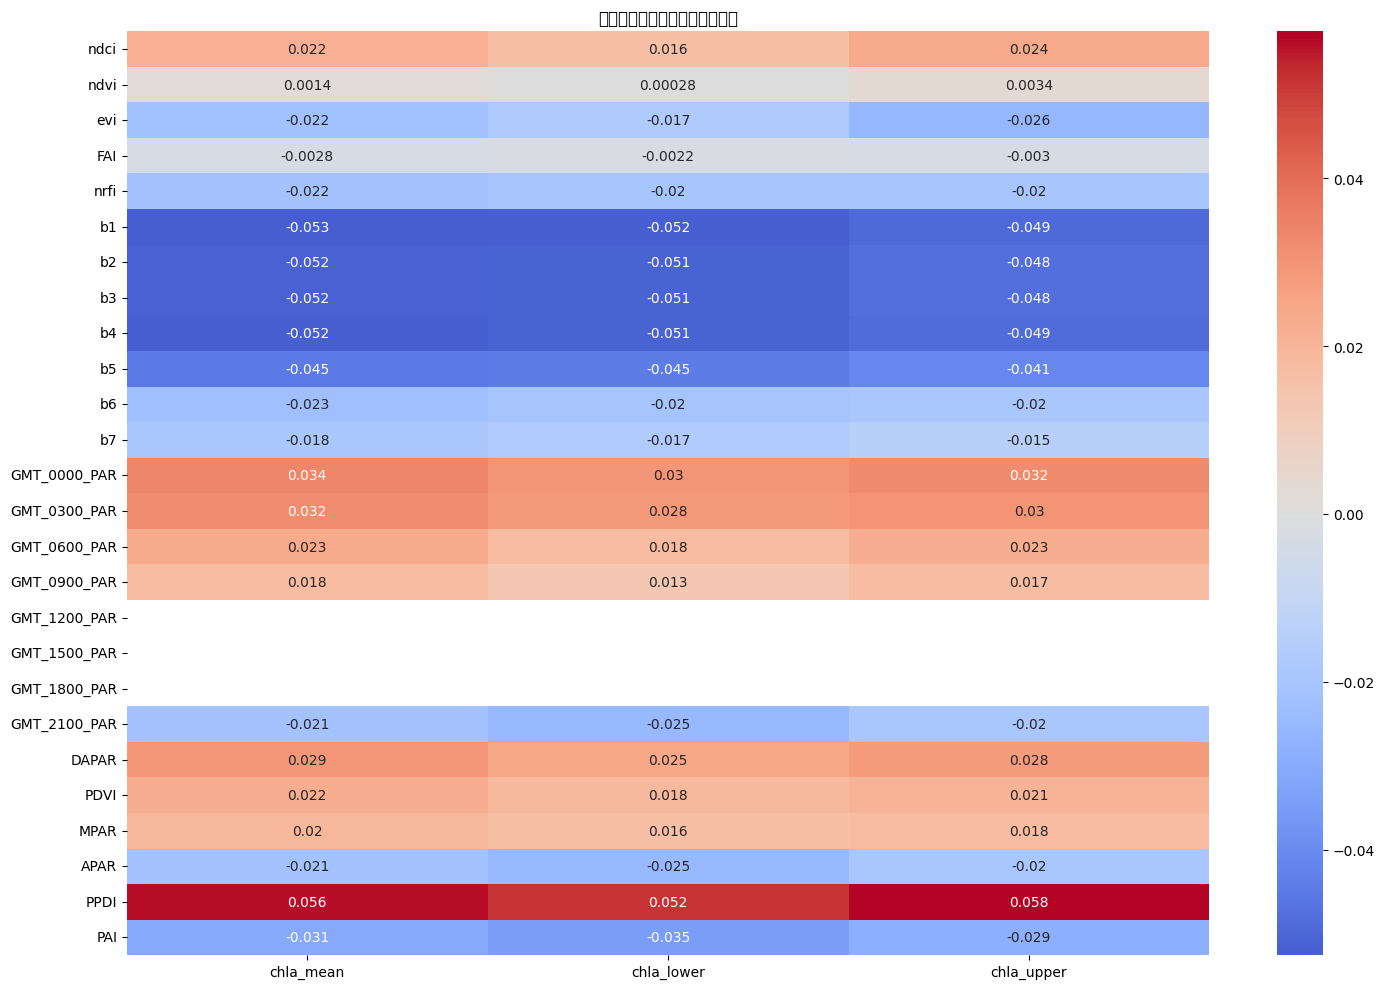

In [3]:
# 将日期列转换为datetime类型
merged_df['date'] = pd.to_datetime(merged_df['date'])

# 定义特征列
features = ['ndci', 'ndvi', 'evi', 'FAI', 'nrfi', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7',
           'GMT_0000_PAR', 'GMT_0300_PAR', 'GMT_0600_PAR', 'GMT_0900_PAR', 'GMT_1200_PAR',
           'GMT_1500_PAR', 'GMT_1800_PAR', 'GMT_2100_PAR', 'DAPAR', 'PDVI', 'MPAR', 'APAR',
           'PPDI', 'PAI']

# 定义目标变量
targets = ['chla_mean', 'chla_lower', 'chla_upper']

# 计算特征和目标之间的相关性
correlations = {}
for target in targets:
    correlations[target] = {}
    for feature in features:
        corr = merged_df[feature].corr(merged_df[target])
        correlations[target][feature] = corr

# 为每个目标变量打印排序后的相关性
for target in targets:
    print(f"\n{target} 与各特征的相关性排序:")
    sorted_corr = sorted(correlations[target].items(), key=lambda x: abs(x[1]), reverse=True)
    for feature, corr in sorted_corr:
        print(f"{feature}: {corr:.4f}")

# 绘制热力图
import seaborn as sns
plt.figure(figsize=(15, 10))
corr_matrix = pd.DataFrame(index=features)
for target in targets:
    corr_matrix[target] = [correlations[target][feature] for feature in features]
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('特征与目标变量的相关性热力图')
plt.tight_layout()
plt.show()
